In [2]:
#import files
%matplotlib inline

import os
from pathlib import Path
import shutil
import re

import tifffile
import glob
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Image Processing Demonstration
To process images, here is the general file organization that we will need.
```
base_directory/ 
├── working_directory/
│   ├── data/ 
│   │   ├── autofluorescence_directory/ 
│   │   │   └── ...tif
│   │   └── signal_directory/ 
│   │       └── ...tif
│   ├── analysis/
│   │   └── ...
│   ├── parameter.py
│   └── process.py
├── filters/
│   └── ilastik_filter.ipl
├── 00_bq3d_setup.ipynb
├── 01_bq3d_tutorial.ipynb
├── parameter_template.py
├── process_template.py
├── 01_bq3d_tutorial.ipynb
└── bq3d_env.json
```
We will need to manually update the parameter.py file with a few paths to ensure the process.py pipeline is accessing the correct folders.
This notebook will create the working directory folder.

## 0.5. Ensure that the Jupyter Notebook kernel has been changed to the "bq3d" environment!
You can modify this in the Kernel > Change Kernel option in the menu bar.

## 1. Create working directory and set up as a variable in parameter.py
First, create the folder that will serve as the working directory where the analysis and data folders will be stored. The process.py and parameters.py files will be copied over. 

In [3]:
base_directory = Path.cwd()
print("base directory path:", base_directory)

working_directory_name = "demo"  #NOTE: change this to any desired base directory name

#create a base folder in the working directory
working_directory = Path(base_directory, working_directory_name)
Path(working_directory).mkdir(parents=True, exist_ok=True)

#copy parameter and process files from the base directory into the working directory
if "parameter" not in [path.stem for path in Path(working_directory).iterdir() if path.is_file()]:
    print(f"copying parameter and process files into {working_directory} ...")
    shutil.copy(Path(base_directory, "parameter_template.py"), Path(working_directory, "parameter.py"))
    shutil.copy(Path(base_directory, "process_template.py"), Path(working_directory, "process.py"))
    print(f"done")

#create data and analysis folders
if "data" not in [path.stem for path in Path(working_directory).iterdir() if path.is_file()]:
    Path(working_directory, "data").mkdir(parents=True, exist_ok=True)
    
if "analysis" not in [path.stem for path in Path(working_directory).iterdir() if path.is_file()]:
    Path(working_directory, "analysis").mkdir(parents=True, exist_ok=True)

base directory path: /mnt/d/brainquant_RC/bq3d_demo


You will need to change the WorkingDirectory variable in the working_directory/parameter.py file so the program knows the path to the working directory:

In [5]:
print(f"\nReplace these variables in working_directory/parameter.py (line 11):\nWorkingDirectory = str(Path('{working_directory}'))")


Replace these variables in working_directory/parameter.py (line 11):
WorkingDirectory = str(Path('/mnt/d/brainquant_RC/bq3d_demo/demo'))


## 2. Move data into the working directory and set up as a variable in parameter.py
Move the downloaded data files into the working_directory/data directory. Ensure that two separate folders containing separated autofluorescence and signal TIF images are within the data directory. 

We will update the parameters.py file here too.

In [5]:
#get subfolders of the raw data
data_subfolders = [path for path in Path(working_directory, "data").iterdir() if path.is_dir()]
print("found these directories in the working_directory/data folder:",[path.stem for path in data_subfolders])

try:
    #adjust the order as necessary
    autofluorescence_directory = data_subfolders[0] 
    signal_directory = data_subfolders[1] 

    # uncomment in case the folder order is reversed
    # autofluorescence_directory = data_subfolders[1] 
    # signal_directory = data_subfolders[0] 

    print("\nAre the following paths correct?")
    print("autofluorescence files are located in",autofluorescence_directory.stem)
    print("signal files are located in",signal_directory.stem)
    print("\nIf the order is incorrect, swap the order of the files by uncommenting lines 10-11 in this code block.")
except Exception as e:
    print(f"Exception: {e} -- make sure to move both of the autofluorescence and signal folders into the working_directory/data directory!")

found these directories in the working_directory/data folder: ['background', 'signal']

Are the following paths correct?
autofluorescence files are located in background
signal files are located in signal

If the order is incorrect, swap the order of the files by uncommenting lines 10-11 in this code block.


You will need to change the AutofluoFile and SignalFile variables in the working_directory/parameter.py file so the program knows where to find the autofluorescence and signal image files:

In [6]:
#replace regex as necessary-- consider which variables in the image name are marking the Z-index. 
autofluo_regex = re.sub(r"Z\d{3,4}", "Z\\\d{3,4}", [path.stem for path in autofluorescence_directory.iterdir()][0])
signal_regex = re.sub(r"Z\d{3,4}", "Z\\\d{3,4}", [path.stem for path in signal_directory.iterdir()][0])

print(f'replace these variables in parameter.py (lines 16, 18=7):\nAutofluoFile = str(Path(DataDirectory, "{autofluorescence_directory.stem}", "{autofluo_regex}.tif"))\nSignalFile = str(Path(DataDirectory, "{signal_directory.stem}", "{signal_regex}.tif"))')

replace these variables in parameter.py (lines 16, 18=7):
AutofluoFile = str(Path(DataDirectory, "background", "NN_428180_463220_025000_left_T001_Z\d{3,4}_C01.tif"))
SignalFile = str(Path(DataDirectory, "signal", "787287_428180_463220_025000_full_sagittal_left_T001_Z\d{3,4}_C01.tif"))


## 3. Change variable in the ilastik.py bq3d file to use an ilastik filter
First, we will locate the ilastik.py file on your computer. Please open the .py file up in your text editor of choice."

In [22]:
import bq3d
#find the ilastik folder in the bq3d package
bq3d_package_directory = Path(bq3d.__file__).parent
ilastik_file = Path(bq3d_package_directory, "image_filters", "filters", "ilastik.py")

assert ilastik_file.is_file(), f'cannot find ilastik file at {ilastik_file}'

print(f"Edit the ilastik.py file by entering this in the command line:\nnano {ilastik_file}\n\nHINT: Use the arrow keys to navigate through the file. You can right-click to paste text from your clipboard.")

Edit the ilastik.py file by entering this in the command line:
nano /home/ninc-user/miniconda3/envs/bq3d/lib/python3.9/site-packages/bq3d/image_filters/filters/ilastik.py

HINT: Use the arrow keys to navigate through the file. You can right-click to paste text from your clipboard.


Second, we want to find the specific .ilp file to put into the ilastik.py file:

In [19]:
ilp_files = glob.glob(str(Path(base_directory,"filters","*.ilp")),recursive=True)
print("Found these .ilp ilastik filter files in the base directory:", ilp_files)

Found these .ilp ilastik filter files in the base directory: ['/mnt/d/brainquant_RC/bq3d_demo/filters/cfos_6h_nov2.ilp']


Finally, we want to replace the self.project variable in the ilastik.py file with the filter path that you would like to use:

In [24]:
print(f"\nReplace variable in ilastik.py file (line 50) with the desired ilp file from list above. For example, it should look like this:\nself.project = '{ilp_files[0]}'\n\nSave the file with the 'Exit' command (usually ^X), followed by Y, and then Enter.")


Replace variable in ilastik.py file (line 50) with the desired ilp file from list above. For example, it should look like this:
self.project = '/mnt/d/brainquant_RC/bq3d_demo/filters/cfos_6h_nov2.ilp'

Save the file with the 'Exit' command (usually ^X), followed by Y, and then Enter.


## 4. Check if you have the Brain Atlas Registration path set up in parameter.py
Find the PathReg variable in parameter.py (line 35) and confirm that it is correct. Make sure that you have your Brain Atlas Registration path set up if you haven't already.

In [26]:
brain_atlas_directory = "/mnt/d/brainquant_RC/bq3d_demo/Warping" #!!! modify the path to the downloaded brain atlas directory on your computer

assert any(Path(brain_atlas_directory).iterdir()), "No files found in the brain atlas directory. Make sure that the path is correct!"

print(f"\nreplace this variable in parameter.py (line 35) if it has not been set already:\nPathReg = str(Path('{brain_atlas_directory}'))")


replace this variable in parameter.py (line 35) if it has not been set already:
PathReg = str(Path('/mnt/d/brainquant_RC/bq3d_demo/Warping'))


# Check TIF files
use FIJI or run the code below to look at the TIF files that will be processed. The code block below will combine all the tif files in the data folder into a stack.

In [27]:
combined_tifs = {} #key as the folder name, value as 3xNxM arrays of intensities (tifffile images)
for path in data_subfolders:
    combined_tifs[path.stem] = tifffile.imread(glob.glob(str(path)+"/*.tif"))

This code will average all pixels across the z-axis of the stack.

background tif shape (Z, Y, X): (247, 2049, 867)
signal tif shape (Z, Y, X): (247, 2049, 867)


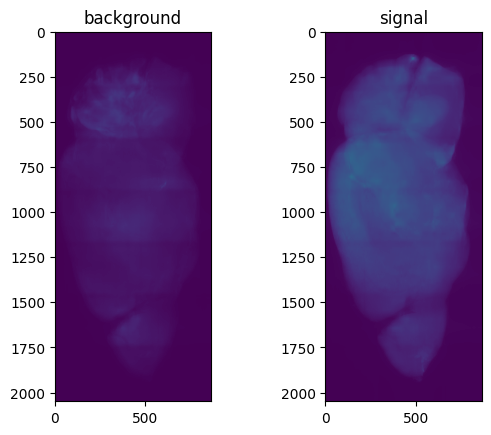

In [29]:
#explore data-- average across z axis
fig, ax = plt.subplots(nrows=1, ncols=len(combined_tifs))
for i, subfolder in enumerate(combined_tifs.keys()):
    print(f"{subfolder} tif shape (Z, Y, X):", combined_tifs[subfolder].shape)
    ax[i].imshow(combined_tifs[subfolder].mean(axis=0),vmin=0, vmax=1000)
    ax[i].set_title(subfolder)

This code will allow you to look at the images on specific layers of the stack.

In [18]:
# https://stackoverflow.com/questions/58489679/continious-update-of-matplotlib-plot-in-jupyter
from IPython.display import display, clear_output
import ipywidgets as ipy
import matplotlib.pyplot as plt
import numpy as np

###NOTE: comment/uncomment to look at figures in specific folder:
folder = '787287_cfos_left_hemi_grayscale'
#folder = '787287_NN_left_hemi_grayscale'

image_stack = combined_tifs[folder]

out = ipy.Output()

# show random mesh
def update(idx):
    with out:
        clear_output()
        fig, ax = plt.subplots(figsize = (5,5))
        h = ax.imshow(image_stack[slider.value], vmin=0, vmax=500) ###NOTE: you may need to adjust vmax for the optimal render.
        # h.set_data(np.ma.masked_less_equal(image_stack[0], slider.value))
        fig.canvas.flush_events()
        fig.canvas.draw()
        plt.show()

slider = ipy.IntSlider(min = 0, max = len(image_stack)-1, orientation = 'vertical')
widget = ipy.interactive(update, idx = slider)

layout = ipy.Layout()

widgets = ipy.HBox(children=(slider, out), layout = layout)
display(widgets)

# 3. Run processing!

In [7]:
os.chdir(Path(working_directory))

In [8]:
!pwd
!python process.py #replace lifecanvas with the name of your working directory

/mnt/d/brainquant_RC/bq3d_demo/demo
VERBOSE |16:15:09| Copying raw data to: /tmp/bq3daff47425-a803-44e1-bbc6-af5c83b18e93/1dbffc85-3316-497f-b470-e5e3083de8f0.tif
VERBOSE |16:15:14| Number of chunks: 1
INFO    |16:15:14| chunk ranges: z= [0, 247], y= [0, 2049], x = [0, 867]
INFO    |16:15:14| Creating memory mapped substack at: /tmp/bq3daff47425-a803-44e1-bbc6-af5c83b18e93/runcdc2e751-c9fe-484a-8153-9aaac9c51038/c0a9ab5c-1436-4b8f-a544-65280c0bc6af.tif
INFO    |16:15:15| Creating raw substack at: /tmp/bq3daff47425-a803-44e1-bbc6-af5c83b18e93/runcdc2e751-c9fe-484a-8153-9aaac9c51038/8484313a-679b-4c25-8f42-11b71ae57f71.tif
VERBOSE |16:15:16| PixelClassification| ram: 4
VERBOSE |16:15:16| PixelClassification| processes: 1
VERBOSE |16:15:16| PixelClassification| project: /mnt/d/brainquant_RC/bq3d_demo/filters/cfos_6h_nov2.ilp
VERBOSE |16:15:16| PixelClassification| output_channel: 0
VERBOSE |16:15:16| PixelClassification| cleanup: False
VERBOSE |16:15:16| PixelClassification| subStack: Non

DEBUG lazyflow.operators.classifierOperators: Features took 1.629046 seconds. Prediction took 6.194948 seconds. Subregion: start '[20, 0, 0, 0]' stop '[21, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.68717 seconds. Prediction took 6.274802 seconds. Subregion: start '[21, 0, 0, 0]' stop '[22, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.636594 seconds. Prediction took 6.104516 seconds. Subregion: start '[22, 0, 0, 0]' stop '[23, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.699726 seconds. Prediction took 6.318663 seconds. Subregion: start '[23, 0, 0, 0]' stop '[24, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.610283 seconds. Prediction took 6.235936 seconds. Subregion: start '[24, 0, 0, 0]' stop '[25, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.691317 seconds. Prediction took 6.604265 seconds. Subregion: start '[25, 0, 0, 0]' s

DEBUG lazyflow.operators.classifierOperators: Features took 1.661143 seconds. Prediction took 6.554756 seconds. Subregion: start '[68, 0, 0, 0]' stop '[69, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.801936 seconds. Prediction took 6.345525 seconds. Subregion: start '[69, 0, 0, 0]' stop '[70, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.711407 seconds. Prediction took 6.435936 seconds. Subregion: start '[70, 0, 0, 0]' stop '[71, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.617028 seconds. Prediction took 6.685886 seconds. Subregion: start '[71, 0, 0, 0]' stop '[72, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.864738 seconds. Prediction took 6.487407 seconds. Subregion: start '[72, 0, 0, 0]' stop '[73, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.8359779999999999 seconds. Prediction took 6.369506 seconds. Subregion: start '[73, 

DEBUG lazyflow.operators.classifierOperators: Features took 1.8199589999999999 seconds. Prediction took 6.700385 seconds. Subregion: start '[116, 0, 0, 0]' stop '[117, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.7112720000000001 seconds. Prediction took 7.267498 seconds. Subregion: start '[117, 0, 0, 0]' stop '[118, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.7566199999999998 seconds. Prediction took 6.778421 seconds. Subregion: start '[118, 0, 0, 0]' stop '[119, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.846943 seconds. Prediction took 6.745635 seconds. Subregion: start '[119, 0, 0, 0]' stop '[120, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.865232 seconds. Prediction took 7.130918 seconds. Subregion: start '[120, 0, 0, 0]' stop '[121, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.789815 seconds. Prediction took 7.01885 sec

DEBUG lazyflow.operators.classifierOperators: Features took 1.8638249999999998 seconds. Prediction took 7.037945 seconds. Subregion: start '[163, 0, 0, 0]' stop '[164, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.928563 seconds. Prediction took 7.356602 seconds. Subregion: start '[164, 0, 0, 0]' stop '[165, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.882665 seconds. Prediction took 7.0965 seconds. Subregion: start '[165, 0, 0, 0]' stop '[166, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.868852 seconds. Prediction took 6.712606 seconds. Subregion: start '[166, 0, 0, 0]' stop '[167, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.8462049999999999 seconds. Prediction took 6.809562 seconds. Subregion: start '[167, 0, 0, 0]' stop '[168, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.621189 seconds. Prediction took 7.07643 seconds. Subreg

DEBUG lazyflow.operators.classifierOperators: Features took 1.532689 seconds. Prediction took 7.258978 seconds. Subregion: start '[210, 0, 0, 0]' stop '[211, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.784347 seconds. Prediction took 6.950539 seconds. Subregion: start '[211, 0, 0, 0]' stop '[212, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.872735 seconds. Prediction took 7.43208 seconds. Subregion: start '[212, 0, 0, 0]' stop '[213, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.91052 seconds. Prediction took 7.077708 seconds. Subregion: start '[213, 0, 0, 0]' stop '[214, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.839229 seconds. Prediction took 7.236871 seconds. Subregion: start '[214, 0, 0, 0]' stop '[215, 2049, 867, 1]'
DEBUG lazyflow.operators.classifierOperators: Features took 1.813011 seconds. Prediction took 7.256602 seconds. Subregion: start '[215, 0

VERBOSE |16:55:10| resample XY: Resampling plane 5 to size: (89, 738)
VERBOSE |16:55:11| resample XY: Resampling plane 6 to size: (89, 738)
VERBOSE |16:55:11| resample XY: Resampling plane 7 to size: (89, 738)
VERBOSE |16:55:11| resample XY: Resampling plane 8 to size: (89, 738)
VERBOSE |16:55:11| resample XY: Resampling plane 9 to size: (89, 738)
VERBOSE |16:55:11| resample XY: Resampling plane 10 to size: (89, 738)
VERBOSE |16:55:11| resample XY: Resampling plane 11 to size: (89, 738)
VERBOSE |16:55:11| resample XY: Resampling plane 12 to size: (89, 738)
VERBOSE |16:55:11| resample XY: Resampling plane 13 to size: (89, 738)
VERBOSE |16:55:12| resample XY: Resampling plane 14 to size: (89, 738)
VERBOSE |16:55:12| resample XY: Resampling plane 15 to size: (89, 738)
VERBOSE |16:55:12| resample XY: Resampling plane 16 to size: (89, 738)
VERBOSE |16:55:12| resample XY: Resampling plane 17 to size: (89, 738)
VERBOSE |16:55:12| resample XY: Resampling plane 18 to size: (89, 738)
VERBOSE |16

VERBOSE |16:55:25| resample XY: Resampling plane 121 to size: (89, 738)
VERBOSE |16:55:26| resample XY: Resampling plane 122 to size: (89, 738)
VERBOSE |16:55:26| resample XY: Resampling plane 123 to size: (89, 738)
VERBOSE |16:55:26| resample XY: Resampling plane 124 to size: (89, 738)
VERBOSE |16:55:26| resample XY: Resampling plane 125 to size: (89, 738)
VERBOSE |16:55:26| resample XY: Resampling plane 126 to size: (89, 738)
VERBOSE |16:55:26| resample XY: Resampling plane 127 to size: (89, 738)
VERBOSE |16:55:26| resample XY: Resampling plane 128 to size: (89, 738)
VERBOSE |16:55:27| resample XY: Resampling plane 129 to size: (89, 738)
VERBOSE |16:55:27| resample XY: Resampling plane 130 to size: (89, 738)
VERBOSE |16:55:27| resample XY: Resampling plane 131 to size: (89, 738)
VERBOSE |16:55:27| resample XY: Resampling plane 132 to size: (89, 738)
VERBOSE |16:55:27| resample XY: Resampling plane 133 to size: (89, 738)
VERBOSE |16:55:27| resample XY: Resampling plane 134 to size: (8

VERBOSE |16:55:41| resample XY: Resampling plane 235 to size: (89, 738)
VERBOSE |16:55:42| resample XY: Resampling plane 236 to size: (89, 738)
VERBOSE |16:55:42| resample XY: Resampling plane 237 to size: (89, 738)
VERBOSE |16:55:42| resample XY: Resampling plane 238 to size: (89, 738)
VERBOSE |16:55:42| resample XY: Resampling plane 239 to size: (89, 738)
VERBOSE |16:55:42| resample XY: Resampling plane 240 to size: (89, 738)
VERBOSE |16:55:42| resample XY: Resampling plane 241 to size: (89, 738)
VERBOSE |16:55:42| resample XY: Resampling plane 242 to size: (89, 738)
VERBOSE |16:55:43| resample XY: Resampling plane 243 to size: (89, 738)
VERBOSE |16:55:43| resample XY: Resampling plane 244 to size: (89, 738)
VERBOSE |16:55:43| resample XY: Resampling plane 245 to size: (89, 738)
VERBOSE |16:55:43| resample XY: Resampling plane 246 to size: (89, 738)
VERBOSE |16:55:43| resampleData: Z: Resampling 0/89
VERBOSE |16:55:43| resampleData: Z: Resampling 50/89
VERBOSE |16:55:43| resampleData